<a href="https://colab.research.google.com/github/SRI-CSL/CoProver/blob/main/src/notebooks/220325_t5/220429_coprover_simplet5_NCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoProver `Simple T5`-transformer experiments

##### **Copyright 2022 SRI International.**

# 🏃‍♀️ Quickstart

In this notebook, we make use of T5 transformer models for **Next Command Prediction (NCP)** task.

## &#9776; Import libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from tqdm import tqdm

In [2]:
try:
  from simplet5 import SimpleT5
except ImportError:
  !pip install --upgrade simplet5

Global seed set to 42


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## &#9881; Define `needed` functions

In [4]:
def score_df(input_model, input_df):
  """a slight modification to EY-method ensuring that we retrieve all 
  the necessary output for the confusion matrix construction as np.array

  Note: Trained input_model should be loaded before executing this method
  """

  num_correct = 0
  total = 0
  pred_labels = []
  true_labels = []

  for idx, row in tqdm(input_df.iterrows(), total=len(input_df)):
    # predicted label
    p_label = input_model.predict(row.source_text)[0]

    # true label
    t_label = row.target_text

    pred_labels.append(p_label)
    true_labels.append(t_label)

    total += 1

    if p_label == t_label:
        num_correct += 1

  return num_correct, total, pred_labels, true_labels

In [5]:
def get_id_from_command(input_command):
    a = list(id_to_target.keys())[list(id_to_target.values()).index(input_command)]
    return a

# &#129529; Data cleaning and preparation

In [6]:
proof_file = 'tags_input_pred_pairs.tsv'

In [7]:
if not os.path.exists(proof_file):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK" -O 'tags_input_pred_pairs.tsv' && rm -rf /tmp/cookies.txt
else:
  print(f"{proof_file} already exists!")

--2022-05-03 02:49:05--  https://docs.google.com/uc?export=download&confirm=&id=1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK
Resolving docs.google.com (docs.google.com)... 108.177.125.138, 108.177.125.101, 108.177.125.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2nmunkcr1jh7n2aj2c12op4evo86ksn3/1651546125000/12981205944103091625/*/1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK?e=download [following]
--2022-05-03 02:49:07--  https://doc-08-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2nmunkcr1jh7n2aj2c12op4evo86ksn3/1651546125000/12981205944103091625/*/1J9xAcdlo8NXRlbz3SQh_GvbVsk90a4jK?e=download
Resolving doc-08-a4-docs.googleusercontent.com (doc-08-a4-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-08-a4-docs.googleusercontent.com (doc-08

In [8]:
# df = pd.read_csv(path)
full_df = pd.read_csv(f'./{proof_file}', sep="\t", header=None, names=['source_text', 'target_text'])

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16065 entries, 0 to 16064
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  16065 non-null  object
 1   target_text  16065 non-null  object
dtypes: object(2)
memory usage: 251.1+ KB


In [10]:
full_df.head()

,source_text,target_text
0,<ANT> <CONS> s-formula forall ['variable'] ['v...,subtype-tcc
1,<ANT> <CONS> s-formula forall ['variable'] ['v...,skosimp*
2,<ANT> <CONS> s-formula apply constant type-act...,apply-extensionality
3,<ANT> <CONS> s-formula apply constant type-act...,grind
4,<ANT> <CONS> s-formula forall ['variable'] ['v...,subtype-tcc


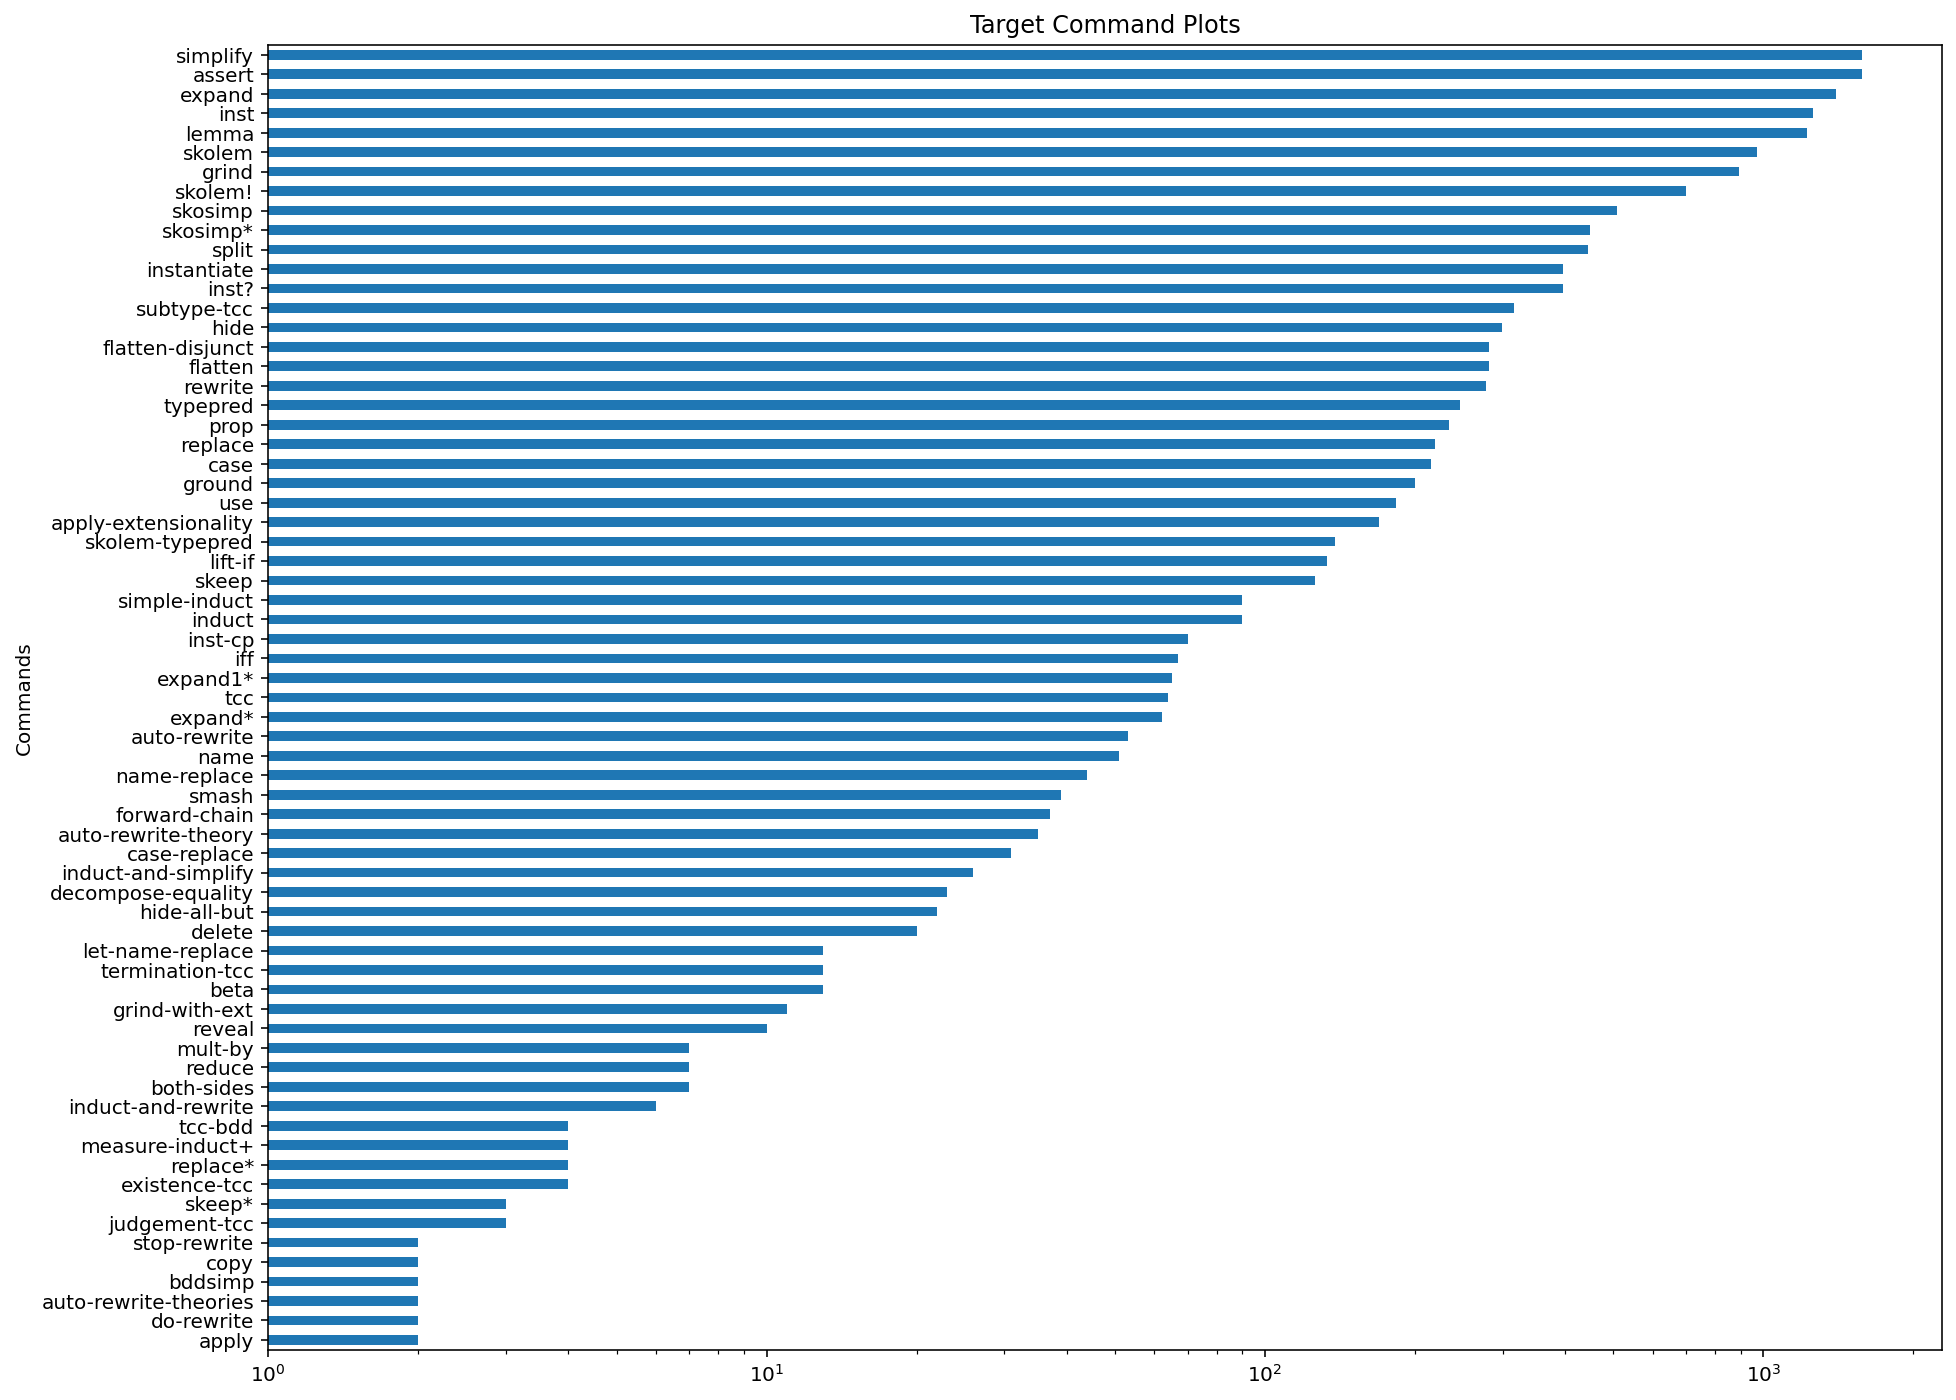

In [11]:
tmp_target = full_df.groupby(full_df.target_text).size().sort_values()
tmp_target.plot.barh(title="Target Command Plots", xlabel="Commands", ylabel="Number of records", log=True, figsize=(15, 12))

In [12]:
full_df.loc[full_df.target_text == 'simplify'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1579 entries, 18 to 16056
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  1579 non-null   object
 1   target_text  1579 non-null   object
dtypes: object(2)
memory usage: 37.0+ KB


In [13]:
full_df.loc[full_df.target_text == 'assert'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578 entries, 19 to 16057
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  1578 non-null   object
 1   target_text  1578 non-null   object
dtypes: object(2)
memory usage: 37.0+ KB


In [14]:
full_df.loc[full_df.target_text == 'tcc'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 20 to 15023
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  63 non-null     object
 1   target_text  63 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [15]:
full_df.loc[full_df.target_text.str.endswith('-tcc')].target_text.unique()

array(['subtype-tcc', 'termination-tcc', 'existence-tcc', 'judgement-tcc'],
      dtype=object)

In [16]:
full_df.loc[full_df.target_text.str.endswith('-tcc')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 0 to 15457
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  332 non-null    object
 1   target_text  332 non-null    object
dtypes: object(2)
memory usage: 7.8+ KB


In [17]:
# delete those records where 'target_text' column == [assert, tcc, *-tcc]
full_df.drop(full_df[(full_df.target_text == 'assert') | (full_df.target_text == 'tcc') | (full_df.target_text.str.endswith('-tcc'))].index, inplace=True)

In [18]:
# removing the assert, tcc, and *-tcc records results in a dataframe with 14,092-records in total
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14092 entries, 1 to 16064
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  14092 non-null  object
 1   target_text  14092 non-null  object
dtypes: object(2)
memory usage: 330.3+ KB


In [19]:
# create a mapping of the target_text to a unique ID value
full_df['target_id'] = full_df['target_text'].factorize()[0]
full_df.head()

,source_text,target_text,target_id
1,<ANT> <CONS> s-formula forall ['variable'] ['v...,skosimp*,0
2,<ANT> <CONS> s-formula apply constant type-act...,apply-extensionality,1
3,<ANT> <CONS> s-formula apply constant type-act...,grind,2
5,<ANT> <CONS> s-formula forall ['variable'] ['v...,skosimp*,0
6,<ANT> <CONS> s-formula apply constant type-act...,apply-extensionality,1


In [20]:
target_df = full_df[['target_id', 'target_text']].drop_duplicates().sort_values('target_id')
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 1 to 15479
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   target_id    61 non-null     int64 
 1   target_text  61 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [21]:
target_df.head()

,target_id,target_text
1,0,skosimp*
2,1,apply-extensionality
3,2,grind
11,3,typepred
13,4,skolem


In [22]:
id_to_target = dict(target_df[['target_id', 'target_text']].values)
id_to_target

{0: 'skosimp*',
 1: 'apply-extensionality',
 2: 'grind',
 3: 'typepred',
 4: 'skolem',
 5: 'skolem!',
 6: 'skosimp',
 7: 'replace',
 8: 'expand',
 9: 'simplify',
 10: 'lemma',
 11: 'instantiate',
 12: 'inst?',
 13: 'inst',
 14: 'case',
 15: 'split',
 16: 'prop',
 17: 'hide',
 18: 'flatten-disjunct',
 19: 'flatten',
 20: 'case-replace',
 21: 'ground',
 22: 'lift-if',
 23: 'rewrite',
 24: 'use',
 25: 'delete',
 26: 'inst-cp',
 27: 'reduce',
 28: 'iff',
 29: 'skolem-typepred',
 30: 'expand1*',
 31: 'expand*',
 32: 'induct-and-simplify',
 33: 'simple-induct',
 34: 'induct',
 35: 'skeep',
 36: 'smash',
 37: 'forward-chain',
 38: 'auto-rewrite',
 39: 'grind-with-ext',
 40: 'name',
 41: 'decompose-equality',
 42: 'name-replace',
 43: 'reveal',
 44: 'auto-rewrite-theory',
 45: 'tcc-bdd',
 46: 'skeep*',
 47: 'beta',
 48: 'induct-and-rewrite',
 49: 'bddsimp',
 50: 'hide-all-but',
 51: 'measure-induct+',
 52: 'let-name-replace',
 53: 'apply',
 54: 'replace*',
 55: 'both-sides',
 56: 'copy',
 57: 

In [23]:
# let's drop the target_id column from the original dataframe to maintain 
# the required simpleT5 structure
full_df.drop('target_id', axis=1, inplace=True)

In [24]:
full_df.head()

,source_text,target_text
1,<ANT> <CONS> s-formula forall ['variable'] ['v...,skosimp*
2,<ANT> <CONS> s-formula apply constant type-act...,apply-extensionality
3,<ANT> <CONS> s-formula apply constant type-act...,grind
5,<ANT> <CONS> s-formula forall ['variable'] ['v...,skosimp*
6,<ANT> <CONS> s-formula apply constant type-act...,apply-extensionality


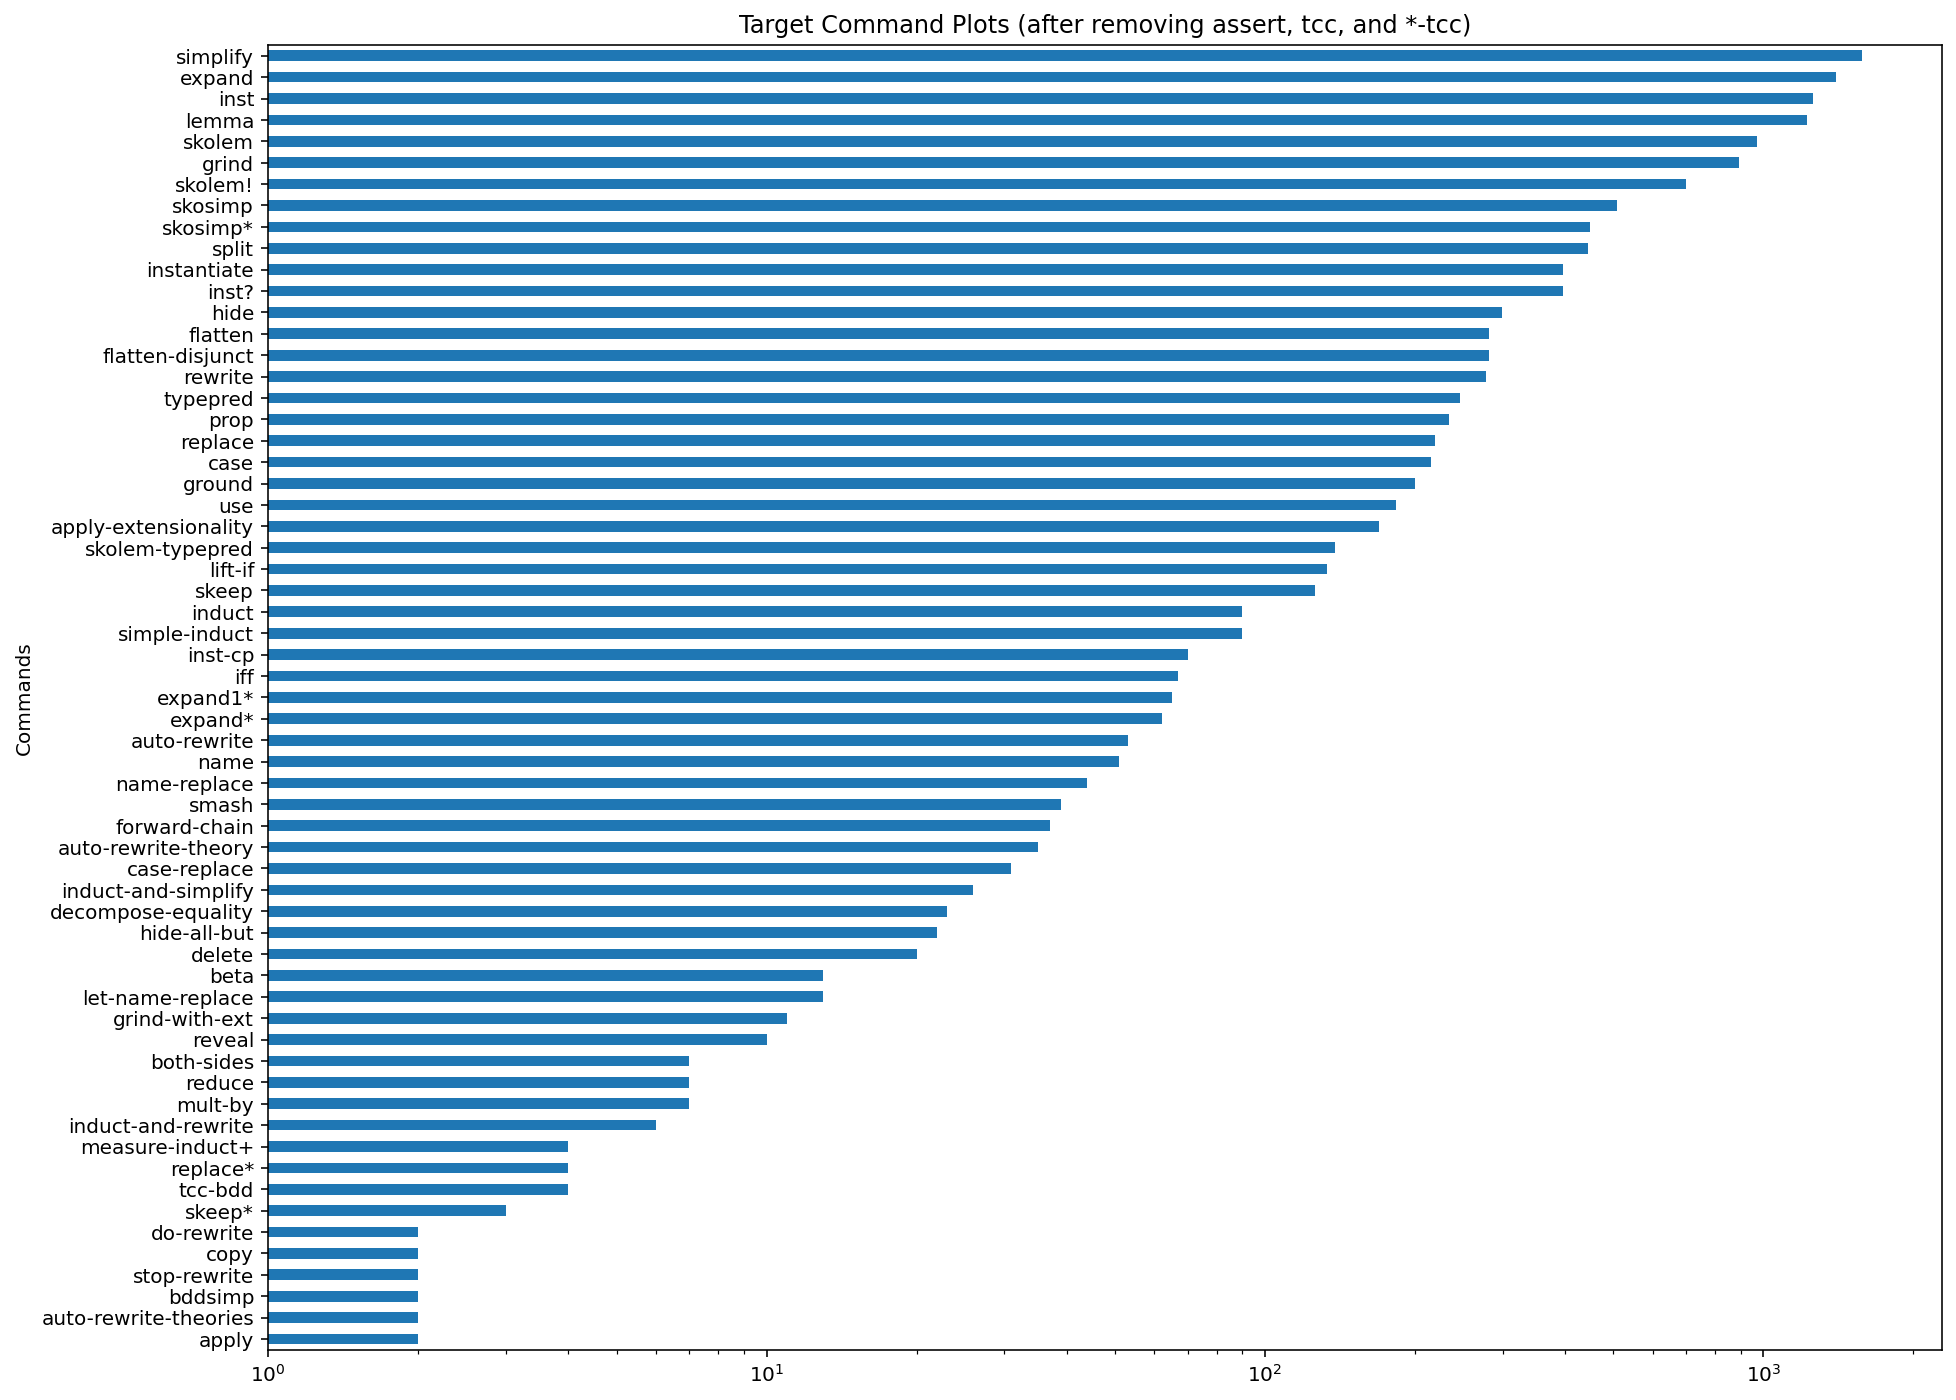

In [25]:
tmp_target_1 = full_df.groupby(full_df.target_text).size().sort_values()
tmp_target_1.plot.barh(title="Target Command Plots (after removing assert, tcc, and *-tcc)", xlabel="Commands", ylabel="Number of records", log=True, figsize=(15, 12))

In [26]:
# Command prefixes are always expected
CMD1_PREFIX = "command1: "

In [27]:
full_df['source_text'] = CMD1_PREFIX + full_df['source_text']

In [28]:
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=1337, shuffle=True)

In [29]:
train_df.shape, test_df.shape

((11273, 2), (2819, 2))

# &#129504; `simpleT5`

## &#128722; T5 Model Load

In [30]:
model = SimpleT5()

In [31]:
model.from_pretrained(model_type="t5", model_name="t5-base")

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [32]:
# download the zipped model from Google folder
model_zip_file = 'curr_best.zip'

if not os.path.exists(model_zip_file):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1aOLRXmQACIimIGaqP3c-N58EaujSciaD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1aOLRXmQACIimIGaqP3c-N58EaujSciaD" -O 'curr_best.zip' && rm -rf /tmp/cookies.txt
else:
  print(f"{model_zip_file} already exists!")

--2022-05-03 02:51:03--  https://docs.google.com/uc?export=download&confirm=t&id=1aOLRXmQACIimIGaqP3c-N58EaujSciaD
Resolving docs.google.com (docs.google.com)... 108.177.125.139, 108.177.125.113, 108.177.125.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lhhjlucgvkvqnlcfj98s64v56p74ngu0/1651546200000/12981205944103091625/*/1aOLRXmQACIimIGaqP3c-N58EaujSciaD?e=download [following]
--2022-05-03 02:51:03--  https://doc-0k-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lhhjlucgvkvqnlcfj98s64v56p74ngu0/1651546200000/12981205944103091625/*/1aOLRXmQACIimIGaqP3c-N58EaujSciaD?e=download
Resolving doc-0k-a4-docs.googleusercontent.com (doc-0k-a4-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0k-a4-docs.googleusercontent.com (doc-0

In [33]:
# unzip
import zipfile
with zipfile.ZipFile(f'./{model_zip_file}', 'r') as zip_ref:
    zip_ref.extractall('./curr_best')

In [34]:
# Load the trained model
# trained_model_path = './outputs/simplet5-epoch-2-train-loss-0.718-val-loss-0.6536'
# trained_model_path = './epoch_1/content/outputs/simplet5-epoch-1-train-loss-0.7747-val-loss-0.7015'
trained_model_path = './curr_best/curr_best'

In [35]:
model.load_model("t5", trained_model_path, use_gpu=True)

## &#129514; Testing

In [41]:
class_names = [id_to_target[key] for key in id_to_target]
class_names, len(class_names)

(['skosimp*',
  'apply-extensionality',
  'grind',
  'typepred',
  'skolem',
  'skolem!',
  'skosimp',
  'replace',
  'expand',
  'simplify',
  'lemma',
  'instantiate',
  'inst?',
  'inst',
  'case',
  'split',
  'prop',
  'hide',
  'flatten-disjunct',
  'flatten',
  'case-replace',
  'ground',
  'lift-if',
  'rewrite',
  'use',
  'delete',
  'inst-cp',
  'reduce',
  'iff',
  'skolem-typepred',
  'expand1*',
  'expand*',
  'induct-and-simplify',
  'simple-induct',
  'induct',
  'skeep',
  'smash',
  'forward-chain',
  'auto-rewrite',
  'grind-with-ext',
  'name',
  'decompose-equality',
  'name-replace',
  'reveal',
  'auto-rewrite-theory',
  'tcc-bdd',
  'skeep*',
  'beta',
  'induct-and-rewrite',
  'bddsimp',
  'hide-all-but',
  'measure-induct+',
  'let-name-replace',
  'apply',
  'replace*',
  'both-sides',
  'copy',
  'do-rewrite',
  'auto-rewrite-theories',
  'stop-rewrite',
  'mult-by'],
 61)

### CFM on the Training Set

In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11273 entries, 3602 to 3651
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  11273 non-null  object
 1   target_text  11273 non-null  object
dtypes: object(2)
memory usage: 264.2+ KB


In [58]:
train_df.describe()

,source_text,target_text
count,11273,11273
unique,6996,60
top,command1: <ANT> s-formula apply constant foral...,simplify
freq,99,1260


In [59]:
correct_preds_tr, total_samples_tr, pred_labels_lst_tr, true_labels_lst_tr = score_df(input_model=model, input_df=train_df)

100%|██████████| 11273/11273 [29:37<00:00,  6.34it/s]


In [61]:
print(f"{correct_preds_tr} samples were predicted CORRECTLY out of {total_samples_tr} samples present in the input DataFrame.\tAccuracy: {correct_preds_tr/total_samples_tr:.3f}")

4873 samples were predicted CORRECTLY out of 11273 samples present in the input DataFrame.	Accuracy: 0.432


In [62]:
p_np_tr = np.array(pred_labels_lst_tr)
t_np_tr = np.array(true_labels_lst_tr) 

In [67]:
# HACK - NEEDS DOUBLE-CHECKING
p_np_updated_tr = ['do-rewrite' if i.startswith('apply rewrite') else i for i in p_np_tr]
p_np_updated_tr_1 = ['let-name-replace' if i.startswith('let-name') else i for i in p_np_updated_tr]

In [68]:
p_np_id_tr = [get_id_from_command(i) for i in p_np_updated_tr_1]
t_np_id_tr = [get_id_from_command(i) for i in t_np_tr]

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay

In [94]:
cf_matrix_training_set = confusion_matrix(t_np_id_tr, p_np_id_tr, normalize='true')
# cf_matrix_training_set = confusion_matrix(t_np_id_tr, p_np_id_tr)

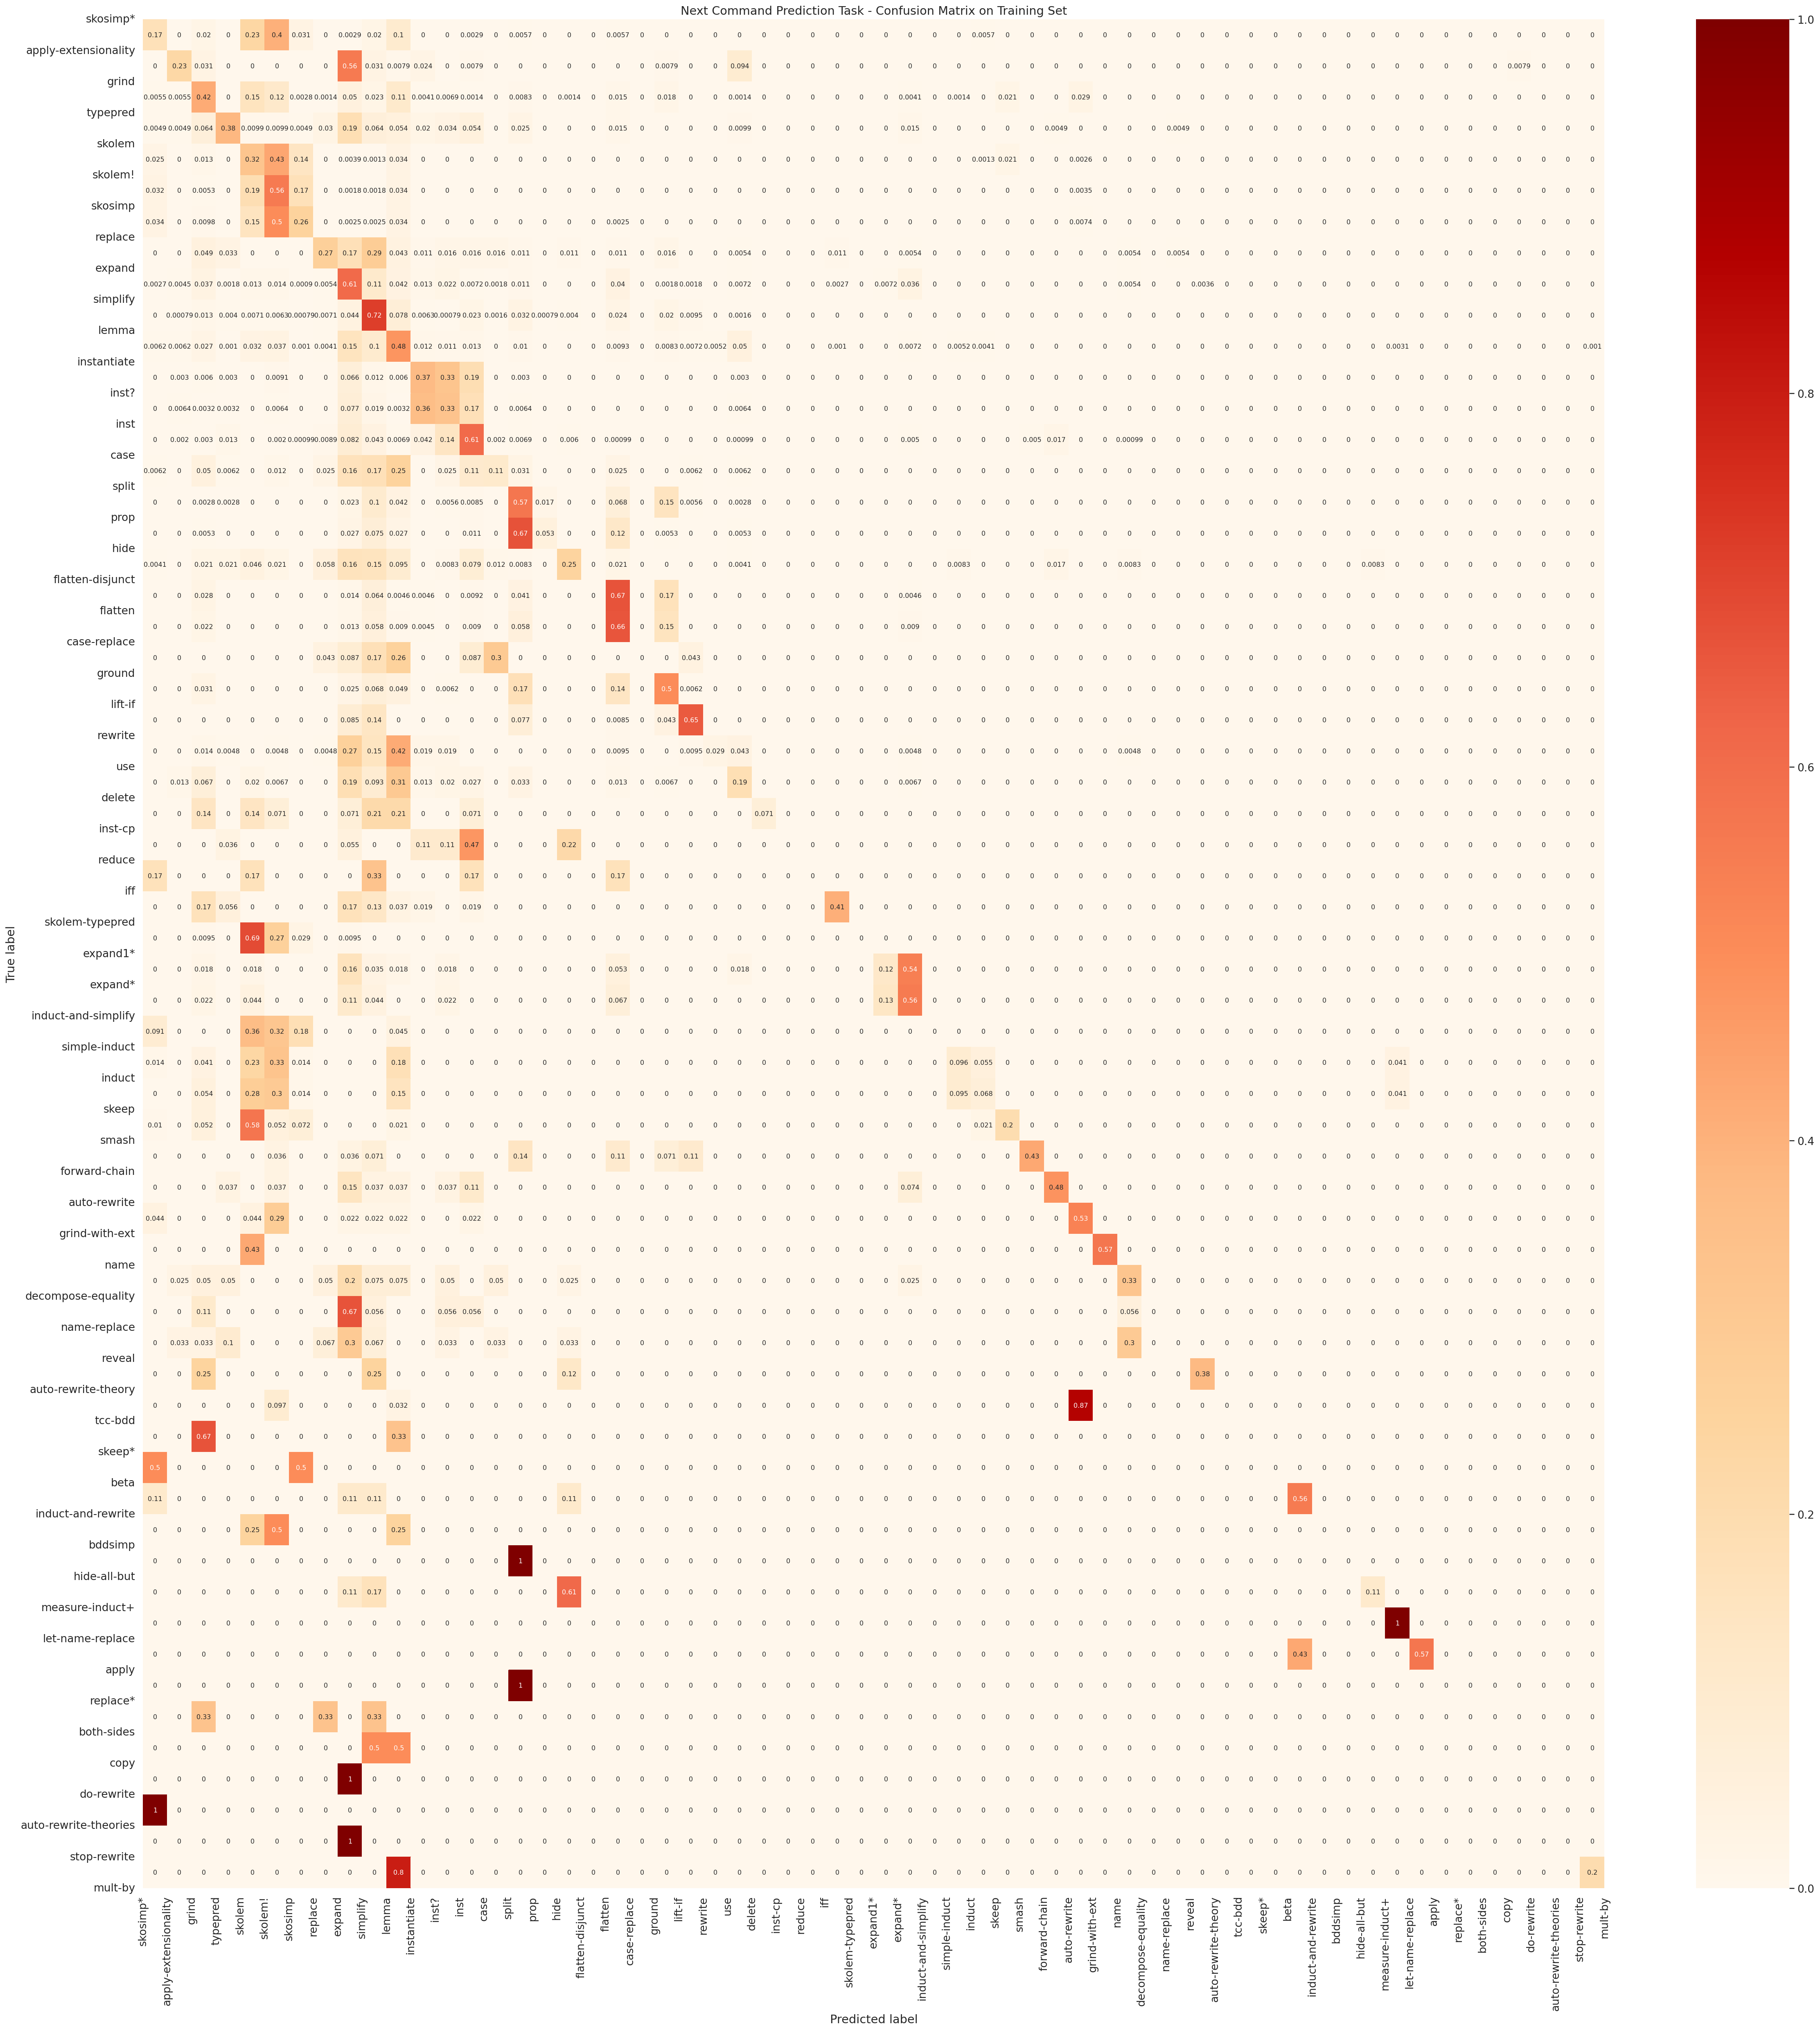

In [98]:
# plt.figure(figsize=(40,40))
# ConfusionMatrixDisplay.from_predictions(t_np_id_tr, p_np_id_tr)
# plt.show()
plt.figure(figsize=(40,42))
# sns.heatmap(cf_matrix_training_set, annot=True, annot_kws={'size':8}, cmap='OrRd', mask=np.eye(len(cf_matrix_training_set)))
sns.heatmap(cf_matrix_training_set, annot=True, annot_kws={'size':8}, cmap='OrRd')

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.2
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Next Command Prediction Task - Confusion Matrix on Training Set')
plt.show()

### CFM on the Testing Set

In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2819 entries, 9896 to 4816
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_text  2819 non-null   object
 1   target_text  2819 non-null   object
dtypes: object(2)
memory usage: 66.1+ KB


In [37]:
test_df.describe()

,source_text,target_text
count,2819,2819
unique,2353,50
top,command1: <ANT> <CONS> s-formula forall ['vari...,simplify
freq,21,319


In [38]:
test_df.head()

,source_text,target_text
9896,command1: <ANT> s-formula apply constant apply...,rewrite
1858,command1: <ANT> s-formula apply constant apply...,expand*
13802,command1: <ANT> <CONS> s-formula forall ['vari...,skosimp
13407,command1: <ANT> <CONS> s-formula forall ['vari...,skolem
9591,command1: <ANT> s-formula apply constant apply...,case


In [39]:
# return num_correct, total, pred_labels, true_labels
correct_preds, total_samples, pred_labels_lst, true_labels_lst = score_df(input_model=model, input_df=test_df)

100%|██████████| 2819/2819 [08:13<00:00,  5.71it/s]


In [40]:
print(f"{correct_preds} samples were predicted CORRECTLY out of {total_samples} samples present in the input DataFrame.\tAccuracy: {correct_preds/total_samples:.3f}")

1183 samples were predicted CORRECTLY out of 2819 samples present in the input DataFrame.	Accuracy: 0.420


In [99]:
p_np = np.array(pred_labels_lst)
t_np = np.array(true_labels_lst) 

In [100]:
# HACK - NEEDS DOUBLE-CHECKING
p_np_updated = ['let-name-replace' if i.startswith('let-name') else i for i in p_np]

In [101]:
p_np_id = [get_id_from_command(i) for i in p_np_updated]
t_np_id = [get_id_from_command(i) for i in t_np]
min(p_np_id), max(p_np_id), min(t_np_id), max(t_np_id)

(0, 52, 0, 60)

In [104]:
cf_matrix = confusion_matrix(t_np_id, p_np_id, normalize='true')
print(cf_matrix)

[[0.25510204 0.         0.03061224 ... 0.         0.         0.        ]
 [0.         0.12195122 0.07317073 ... 0.         0.         0.        ]
 [0.01197605 0.         0.34131737 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.8        0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [105]:
cf_matrix.shape

(50, 50)

In [109]:
len(class_names)

61

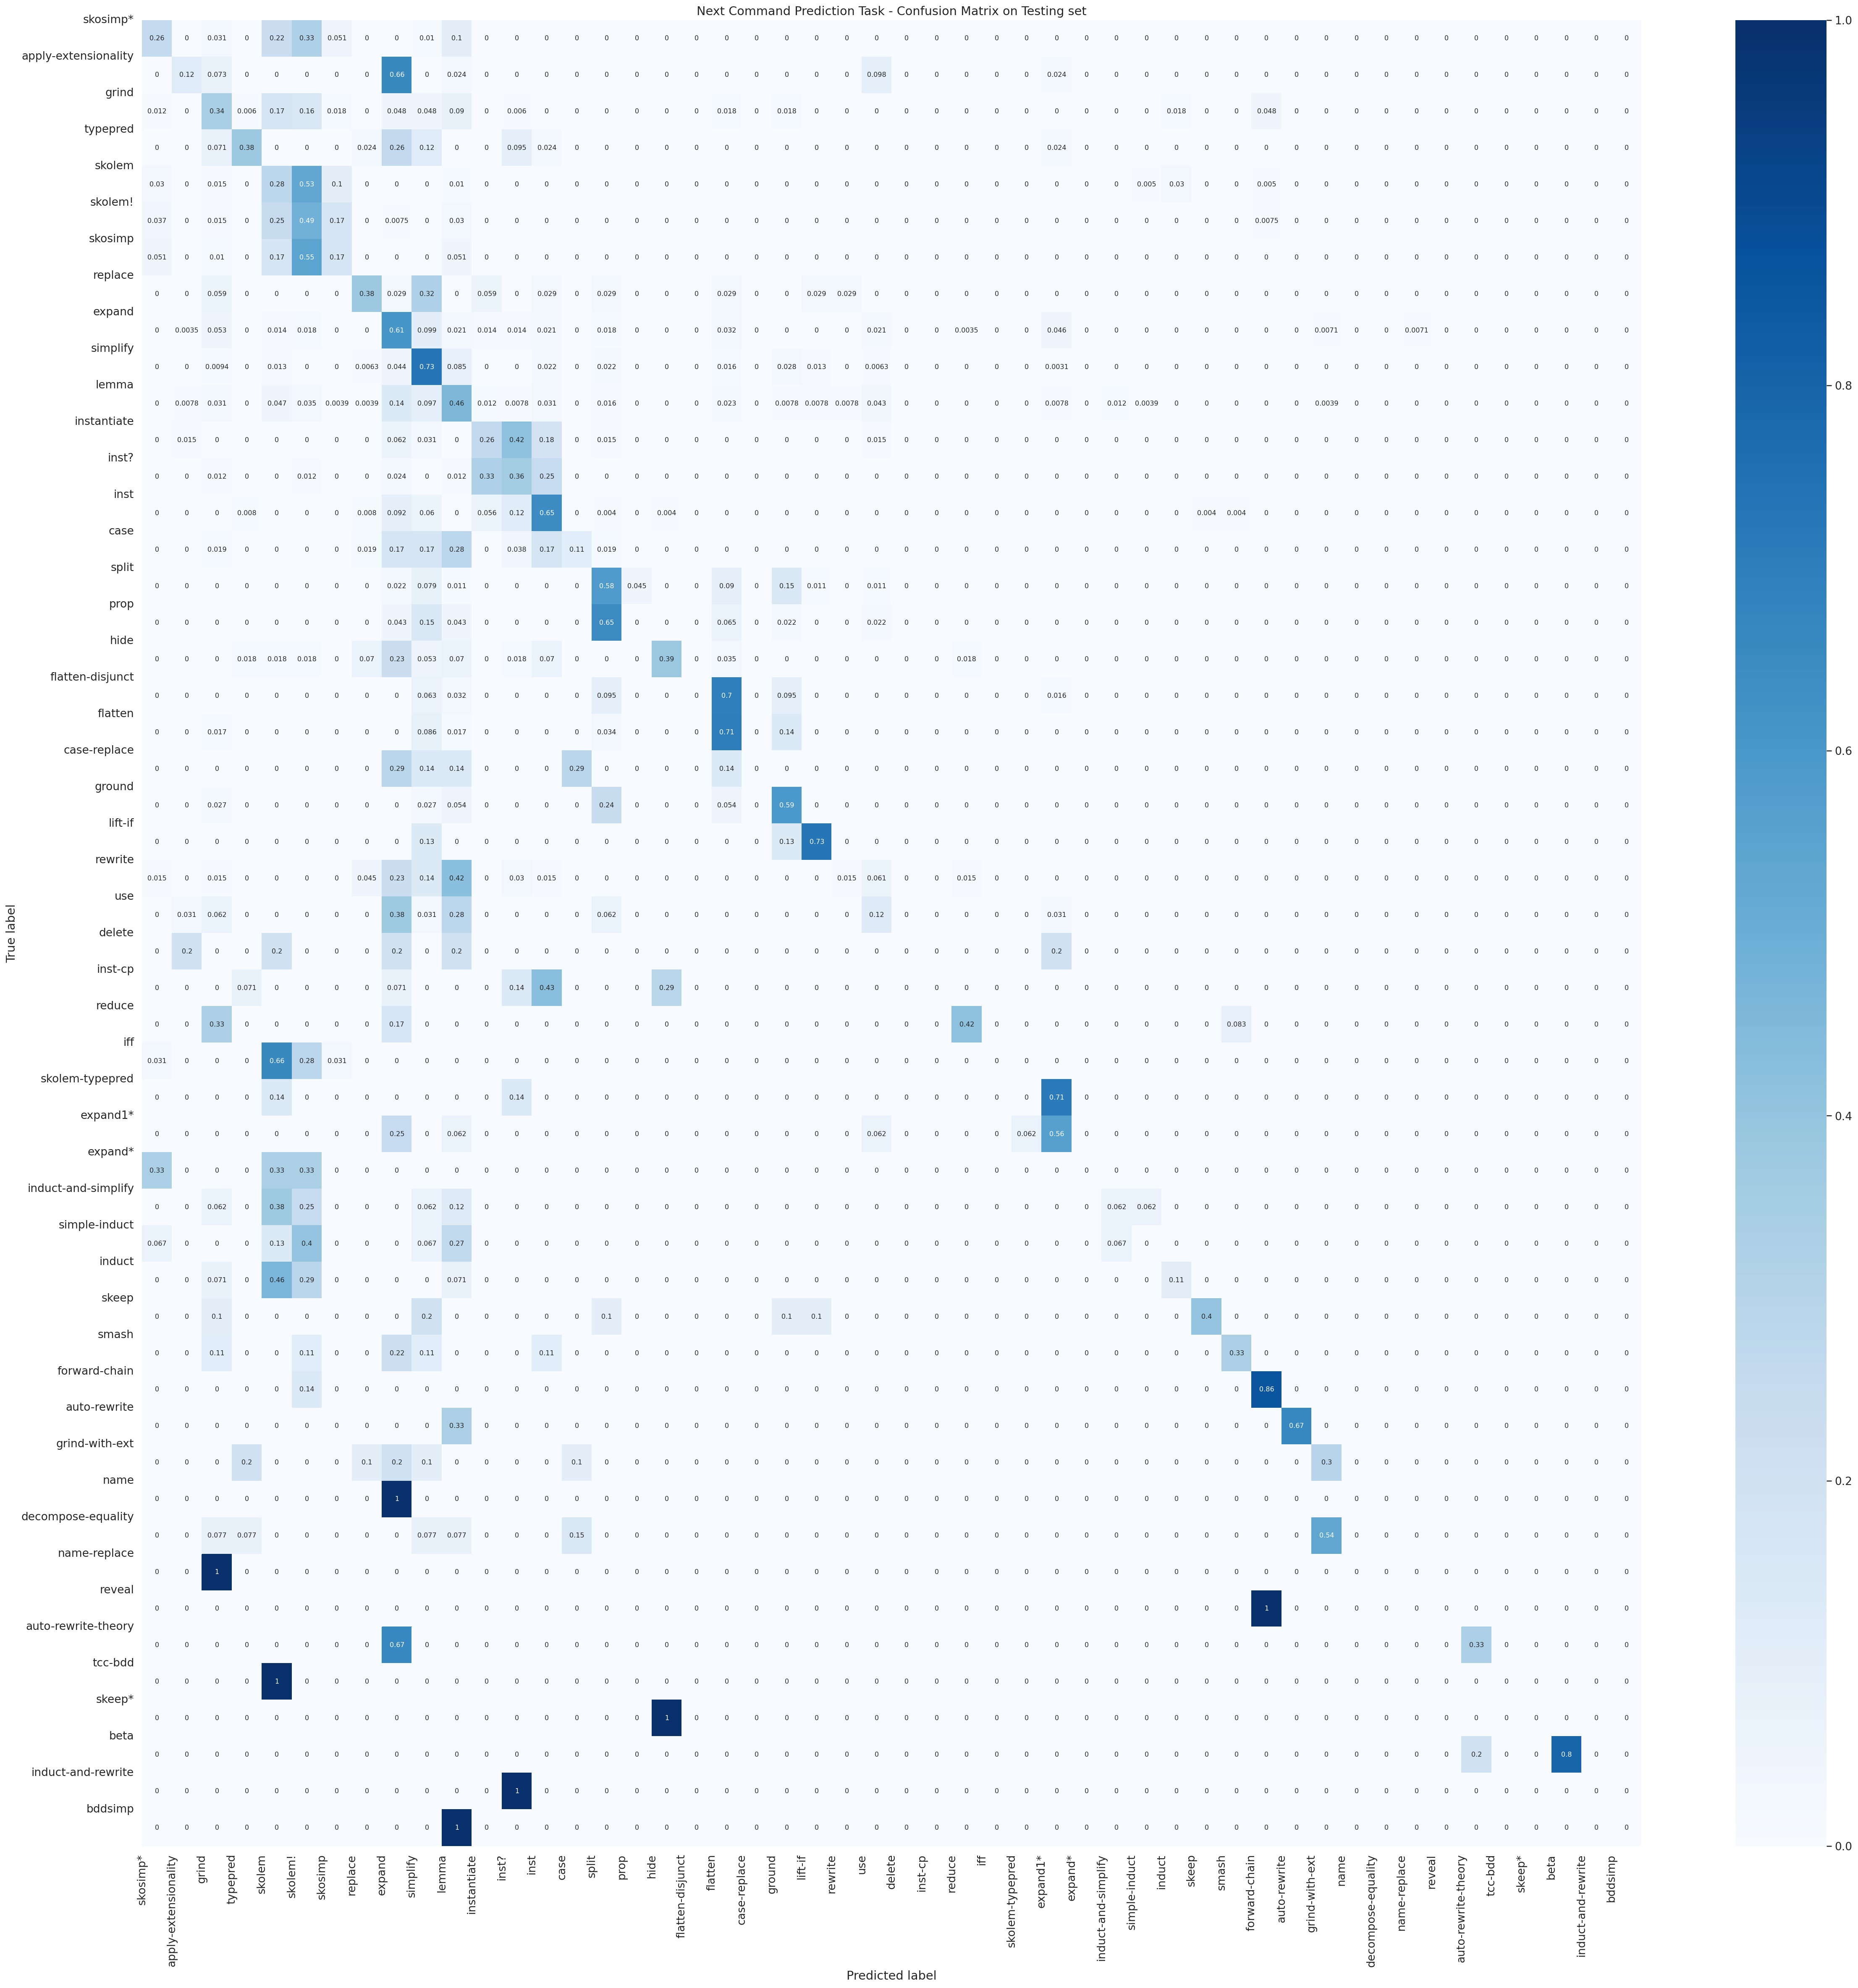

In [110]:
# Build the plot
plt.figure(figsize=(40,40))
# sns.set(font_scale=1.2)
sns.heatmap(cf_matrix, annot=True, annot_kws={'size':8}, cmap='Blues')

tick_marks = np.arange(len(class_names) - 11)
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Next Command Prediction Task - Confusion Matrix on Testing set')
plt.savefig('cf_testing_set.png')
plt.show()

In [52]:
classification = classification_report(t_np_id, p_np_id)
print(classification)

              precision    recall  f1-score   support

           0       0.53      0.26      0.34        98
           1       0.45      0.12      0.19        41
           2       0.48      0.34      0.40       167
           3       0.67      0.38      0.48        42
           4       0.25      0.28      0.26       201
           5       0.20      0.49      0.28       134
           6       0.24      0.17      0.20        99
           7       0.46      0.38      0.42        34
           8       0.46      0.61      0.53       283
           9       0.61      0.73      0.66       319
          10       0.44      0.46      0.45       257
          11       0.25      0.26      0.26        65
          12       0.28      0.36      0.32        83
          13       0.68      0.65      0.66       251
          14       0.55      0.11      0.19        53
          15       0.43      0.58      0.49        89
          16       0.00      0.00      0.00        46
          17       0.73    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### &#127939; Sample runs

In [53]:
input_sequence = "<ANT> <CONS> s-formula forall ['variable'] ['variable'] apply constant type-actual apply constant type-actual type-actual apply constant ['variable'] ['variable'] apply constant apply constant type-actual type-actual ['variable'] apply constant type-actual type-actual ['variable'] <HID>"

print(model.predict(CMD1_PREFIX + input_sequence)[0])

skolem!


In [54]:
def show_sample_outputs(trained_model, input_df):

  for idx, row in input_df.iterrows():
    input_sequence = row.source_text
    y_true = row.target_text
    y_pred = trained_model.predict(input_sequence)[0]

    print(f"- Input sequence: {input_sequence}\n- Expected command: {y_true}\n- Predicted command: {y_pred}\n-------")

In [55]:
# evaluate the model on the first 10-samples from the training set
show_sample_outputs(trained_model=model, input_df=train_df.head(10))

- Input sequence: command1: <ANT> s-formula apply constant apply constant type-actual constant apply constant constant s-formula apply constant forall ['variable'] apply constant apply constant type-actual apply constant constant apply constant ['variable'] apply constant type-actual constant ['variable'] <CONS> s-formula exists ['variable'] apply constant type-actual apply constant ['variable'] constant <HID> s-formula apply constant forall ['variable'] ['variable'] apply constant apply constant type-actual apply constant ['variable'] apply constant ['variable'] apply constant type-actual ['variable'] ['variable']
- Expected command: instantiate
- Predicted command: inst?
-------
- Input sequence: command1: <ANT> s-formula apply constant apply constant apply constant integer constant constant s-formula apply constant forall ['variable'] ['variable'] apply constant apply constant apply constant ['variable'] apply constant integer constant apply constant ['variable'] apply constant inte

In [56]:
# evaluate the model on the first 10-samples from the testing set
show_sample_outputs(trained_model=model, input_df=test_df.head(10))

- Input sequence: command1: <ANT> s-formula apply constant apply constant constant s-formula apply constant apply constant constant <CONS> s-formula apply constant apply constant constant constant <HID> 
- Expected command: rewrite
- Predicted command: expand
-------
- Input sequence: command1: <ANT> s-formula apply constant apply constant constant integer s-formula apply constant apply constant type-actual type-actual constant <CONS> s-formula apply constant type-actual type-actual apply constant type-actual type-actual type-actual constant <HID> s-formula exists ['variable'] ['variable'] apply constant type-actual type-actual ['variable']
- Expected command: expand*
- Predicted command: expand*
-------
- Input sequence: command1: <ANT> <CONS> s-formula forall ['variable'] ['variable'] apply constant type-actual apply ['variable'] apply apply constant ['variable'] ['variable'] ['variable'] <HID> 
- Expected command: skosimp
- Predicted command: skolem!
-------
- Input sequence: comman